# Лабораторная работа №1. Регрессия

**Тема:** *Сравнение линейной регрессии, случайного леса (Random Forest Regressor), градиентного бустинга (XGBoost) на задаче регрессии.*

**Цели:**

- *Научиться строить, оптимизировать и оценивать регрессионные модели.*
- *Понять, как интерпретировать важность признаков (feature importance).*
- *Понять, как увеличивать кол-во признаков (feature tuning).*
- *Исследовать влияние преобразований признаков (фичей), регуляризации и гиперпараметров.*

**Условия:**

- *numpy, pandas, scikit-learn, XGBoost*
- *выбрать датасет для 1-ой и 2-ой лабораторной работы*

**Пункты:**

1. Подготовка данных + Feature Tuning
2. Создание метрик
3. Базовая модель линейной регрессии
4. Улучшение линейной регрессии
5. Случайный лес регрессор
6. Градиентный бустинг (XGBoost)
7. Feature Importance
8. Написание своих реализаций (классы)
9. Подведение итогов


## О команде

| Фамилия И.О.        | Группа | Роль в команде | Что делал                    |
|---------------------|--------|----------------|------------------------------|
| Книга Т.С.          | 309    | Безумец        | ВСЕ                          |

 Датасет: [Titanic](https://www.kaggle.com/datasets/yasserh/titanic-dataset)

## Описание датасета

Этот набор данных связан с пассажирами лайнера **«Титаник»**, потерпевшего крушение.  
Он содержит информацию о пассажирах — их возрасте, поле, классе билета, цене, количестве родственников на борту и других факторах.  
Цель — **предсказать, выжил ли пассажир**, используя предоставленные признаки.  

Набор данных можно рассматривать как **задачу бинарной классификации**, где целевая переменная — `Survived` (1 — выжил, 0 — нет).  
Сложность заключается в **наличии пропусков**, **различных типов данных** (числовые, категориальные, текстовые) и **сильной зависимости признаков** от социально-экономических факторов.  

### Таблица признаков

| №  | Признак        | Тип данных       | Описание                                                                 |
|----|----------------|------------------|--------------------------------------------------------------------------|
| 1  | **PassengerId** | integer          | Уникальный идентификатор пассажира.                                      |
| 2  | **Survived** (target) | integer (0/1)  | Целевой признак: 0 — не выжил, 1 — выжил.                                |
| 3  | **Pclass**      | integer (1–3)    | Класс билета: 1-й (первый), 2-й (второй), 3-й (третий).                  |
| 4  | **Name**        | string           | Полное имя пассажира (содержит обращение: Mr, Mrs, Miss и т. д.).       |
| 5  | **Sex**         | string           | Пол пассажира: male / female.                                            |
| 6  | **Age**         | float            | Возраст пассажира (в годах). Пропуски присутствуют.                      |
| 7  | **SibSp**       | integer          | Количество братьев/сестер и супругов на борту.                           |
| 8  | **Parch**       | integer          | Количество родителей и детей на борту.                                   |
| 9  | **Ticket**      | string           | Номер билета (содержит буквенно-числовые коды, может нести скрытую инфу).|
| 10 | **Fare**        | float            | Стоимость билета (в фунтах стерлингов).                                  |
| 11 | **Cabin**       | string           | Номер каюты (много пропусков, может содержать информацию о палубе).      |
| 12 | **Embarked**    | string (C, Q, S) | Порт посадки: C = Cherbourg, Q = Queenstown, S = Southampton.            |



## 0. Глобальная настройка проекта


In [634]:
RND_SEED = 21

import seaborn as sns, matplotlib.pyplot as plt

## 1. Подготовка данных + Feature Tuning

### 1.1. Загрузка датасета

Загрузка датасета `pd.read_csv(path_to_dataset: str)`

In [635]:
import pandas as pd
import numpy as np

file_path = "/Users/nugget/Downloads/Titanic-Dataset.csv"
df = pd.read_csv(file_path)

Получение статистки по датасету, необходимую для анализа. Подумать что можно сделать и какие выводы нужны.

Посмотрим первые три строки датасета `df.head(n: int)`

In [636]:
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


У нас тут имеется ненужные атрибуты `PassengerId`, `Name`, `Ticket` и `Cabin`. Можем их удалять, ибо они достаточно уникальные и будут только мешать при обучении модели.

In [637]:
for column in ['PassengerId', 'Name', 'Ticket', 'Cabin']:
    if column in df.columns:
        df = df.drop(columns=[column])


In [638]:
df.head(3)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S


### 1.2. Сбор основной информации

Получение общей информации `df.info()`

In [639]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


Для удобства приведём колонки с типом `int64` к типу `float64`.

In [640]:
int_cols = df.select_dtypes(include=['int64']).columns
df[int_cols] = df[int_cols].astype('float64')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    891 non-null    float64
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    float64
 5   Parch     891 non-null    float64
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(6), object(2)
memory usage: 55.8+ KB


Получение всей статистики `df.describe()`

In [641]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Проверка на пропуски данных `df.isnull().sum()`

In [642]:
print(df.isnull().sum())

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64


К сожалению, в данном датасете у многих пассажиров не определён их возраст (у почти каждого пятого). Удалять все эти строки - идея не из лучших, так как у нас данных для обучения становится сильно меньше. Также в двух местах не заполнен порт посадки. Попытаемся залотать дыры.

Начнём с возрастов. Есть несколько способов поправить эту проблему. Самым простым решением является просто взять среднее арифметическое или медиану из всех прописанных возрастов. Медиана тут лучше бы подошла, потому что она больше устойчива к разбросам данных.

Однако, можно поступить более умно. Возраст на «Титанике» сильно зависел от класса и пола (женщины/дети, 1-й класс и т.д.). Групповая медиана лучше отражает локальное распределение, чем одна глобальная.

In [643]:
# Заполняем пропуски в `Age`` медианой внутри групп (Pclass * Sex)
group_median_age = df.groupby(['Pclass', 'Sex'])['Age'].transform('median')
df['Age'] = df['Age'].fillna(group_median_age).fillna(df['Age'].median())

Что касаемо столбца `Embarked` - два пустых значения среди 891 строк - не так страшно. Можно от них избавиться, но можно этого не делать и просто заполнить эти значения чем-то другим. Так как в датасете `Embarked` - это порт посадки, взять среднее значение будет глупо. Поэтому возьмём моду

In [644]:
# Заполняем пропуски в `Embarked` модой
embark_mode = df['Embarked'].mode(dropna=True)[0]
df['Embarked'] = df['Embarked'].fillna(embark_mode)

Теперь проверим наш датасет на наличие нулей!

In [645]:
print(df.isnull().sum())

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


**Вывод**: теперь в датасете нет пропусков!

Посмотрим на распределение целевой переменной

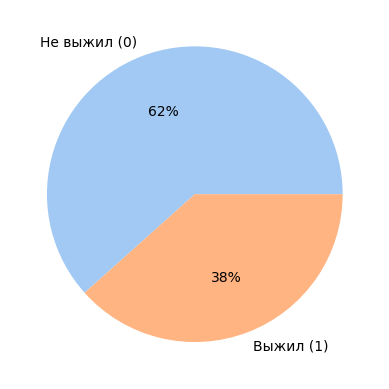

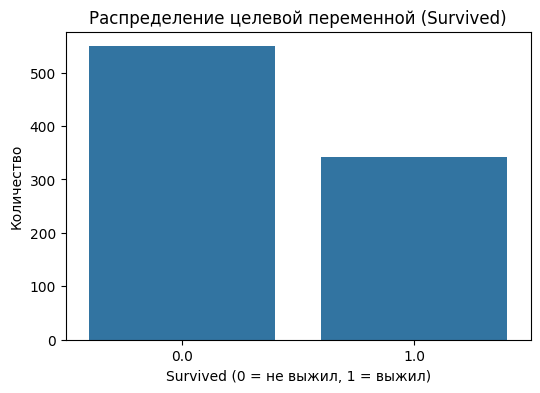

In [646]:
def draw_pie_plot(df: pd.DataFrame, column_name: str):
    explore_column = df[column_name]
    label_map = {0: 'Не выжил (0)', 1: 'Выжил (1)'}
    labels = [label_map.get(v, str(v)) for v in explore_column.value_counts().index]
    params = explore_column.value_counts(normalize=True)

    import seaborn as sns, matplotlib.pyplot as plt
    colors = sns.color_palette('pastel')[0:len(params)]
    plt.pie(params, labels=labels, colors=colors, autopct='%.0f%%')
    plt.show()


def draw_bar_plot(df: pd.DataFrame, column_name: str, title: str):
    import seaborn as sns, matplotlib.pyplot as plt
    plt.figure(figsize=(6,4))
    sns.countplot(x=column_name, data=df)
    plt.title(title)
    plt.xlabel("Survived (0 = не выжил, 1 = выжил)")
    plt.ylabel("Количество")
    plt.show()


draw_pie_plot(df, 'Survived')
draw_bar_plot(df, 'Survived', title="Распределение целевой переменной (Survived)")

**Вывод:** целевая переменная является умеренно несбалансированой.

Посмотрим на корреляцию данных.

***Определение 1: Корреляция данных — это статистическая мера, показывающая, насколько и в каком направлении связаны между собой две переменные.***

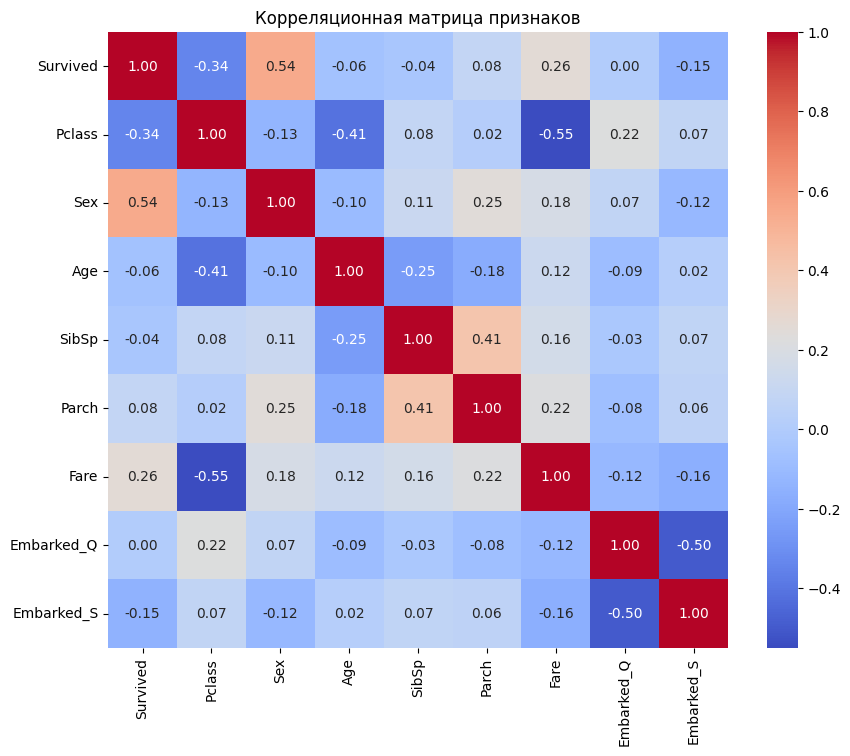

In [647]:
def draw_corr_matrix(df):
    plt.figure(figsize=(10,8))
    sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Корреляционная матрица признаков")
    plt.show()

# Сделаем некоторые поправки в наш датафрейм, чтобы можно было построить корреляционной матрицу

# Кодируем пол: male=0, female=1
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

# One-hot кодировка для Embarked
df = pd.get_dummies(df, columns=['Embarked'], drop_first=True)

# Строим матрицу
draw_corr_matrix(df)

**!!! ВАЖНО !!!**

**ЕСЛИ МЫ СОБИРАЕМСЯ УЧИТЬ ЛИНЕЙНУЮ МОДЕЛЬ, И ДАННЫЕ КОРРЕЛИРУЮТ (МУЛЬТИКОЛЛИНЕАРНОСТЬ), ТО НУЖНО ЛИБО УДАЛИТЬ ОДИН ИЗ ПРИЗНАКОВ, ЛИБО СОЗДАТЬ НОВЫЙ ПРИЗНАК НА ИХ ОСНОВЕ И ИХ УДАЛИТЬ**

### 1.3. Подготовка датасета под разные задачи

Cравнение подготовки

| Модель                  | Масштабирование | Корреляция критична | Выбросы критичны | Feature Engineering рекомендуем                  |
| ----------------------- | --------------- | ------------------- | ---------------- | ------------------------------------------------ |
| Линейная регрессия      | Да              | Да                  | Да               | Полиномы, логарифмы, отношения                   |
| Random Forest Regressor | Нет             | Нет                 | Нет              | Соотношения, интеракции                          |
| XGBoost Regressor       | Нет             | Нет                 | Нет              | Соотношения, интеракции, логарифмы (опционально) |

#### 1.3.1 Линейная регрессия (Linear Regression / Ridge / Lasso)

**Особенности модели:**

- Чувствительна к масштабу признаков и мультиколлинеарности.
- Чувствительна к выбросам.

Сделаем копию датасета

In [648]:
df_linear = df.copy()

Рассмотрим скошенность данных

***Определение 2: Скошенность – это мера асимметрии распределения признака***

* **Скошенность > 0 (положительная):** Хвост распределения тянется вправо (большие значения встречаются реже).

* **Скошенность < 0 (отрицательная):** Хвост распределения тянется влево (малые значения редки).

* **Скошенность ≈ 0:** Практически нормальное распределение (симметричное).


In [649]:
skew_values = df_linear.skew()
skew_values_hard = skew_values[abs(skew_values) > 0.7]  # выделяем сильноскошенные данные
print(skew_values_hard)  # сильно скошенные

skew_columns_hard = list(skew_values_hard.index)
print(f'Скошенные столбцы {skew_columns_hard}')

SibSp         3.695352
Parch         2.749117
Fare          4.787317
Embarked_Q    2.948778
Embarked_S   -1.009665
dtype: float64
Скошенные столбцы ['SibSp', 'Parch', 'Fare', 'Embarked_Q', 'Embarked_S']


Почему вышли такие результаты:
- `Pclass`, `Sex` и `Embarked_?` - это категориальные признаки, которые мы закодировали числами. Их распределения дискретны и они очень часто неравномерно распределены.
- Для `SibSp` и `Parch` большинство значений равно нулю - отсюда сильная положительная скошенность.
- Для `Fare` ярко выраженная правая скошенность (большинство билетов дешёвые, но есть несколько дорогих — до 500). Он будет хорошим кандидатом для логарифмирования.
- `Age` умеренно скошен.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    float64
 1   Pclass      891 non-null    float64
 2   Sex         891 non-null    int64  
 3   Age         891 non-null    float64
 4   SibSp       891 non-null    float64
 5   Parch       891 non-null    float64
 6   Fare        891 non-null    float64
 7   Embarked_Q  891 non-null    bool   
 8   Embarked_S  891 non-null    bool   
dtypes: bool(2), float64(6), int64(1)
memory usage: 50.6 KB


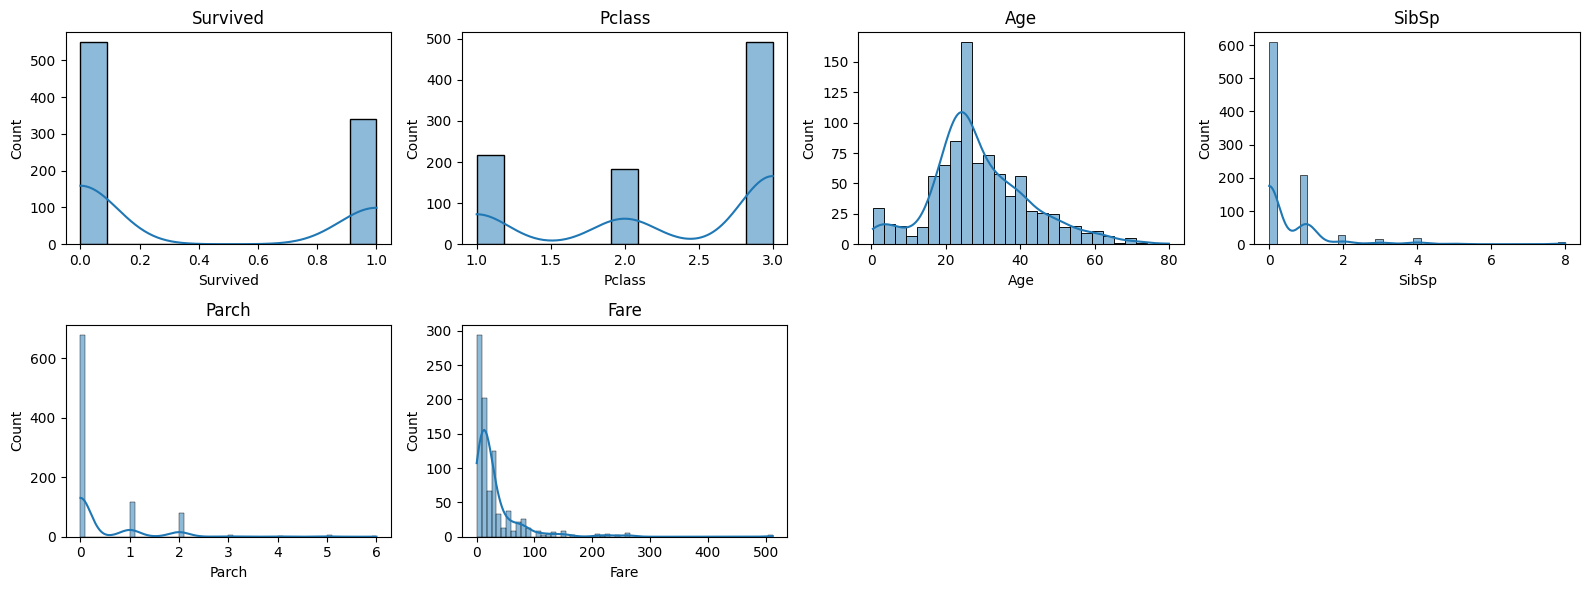

In [650]:
import math

def draw_skew(df: pd.DataFrame, n_cols=4):
    float_cols = df.select_dtypes(include='float').columns
    n_rows = math.ceil(len(float_cols) / n_cols)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
    axs = axs.flatten()  # делаем одномерным массивом для удобства

    for i, col in enumerate(float_cols):
        sns.histplot(df[col], kde=True, ax=axs[i])
        axs[i].set_title(f'{col}')

    # Если графиков меньше, чем ячеек в сетке, скрываем лишние
    for j in range(i+1, len(axs)):
        axs[j].set_visible(False)

    plt.tight_layout()
    plt.show()

df_linear.info()
draw_skew(df_linear)

Можно уменьшить влияние скошенности с помошью:

- Логарифмирование (Уменьшаем положительный хвост)
- Квадратный корень  (сглаживаем умеренные хвосты)
- `Box-Cox` или `Yeo-Johnson` трансформации (более гибкие)

Мы же просто прологарифмируем :)

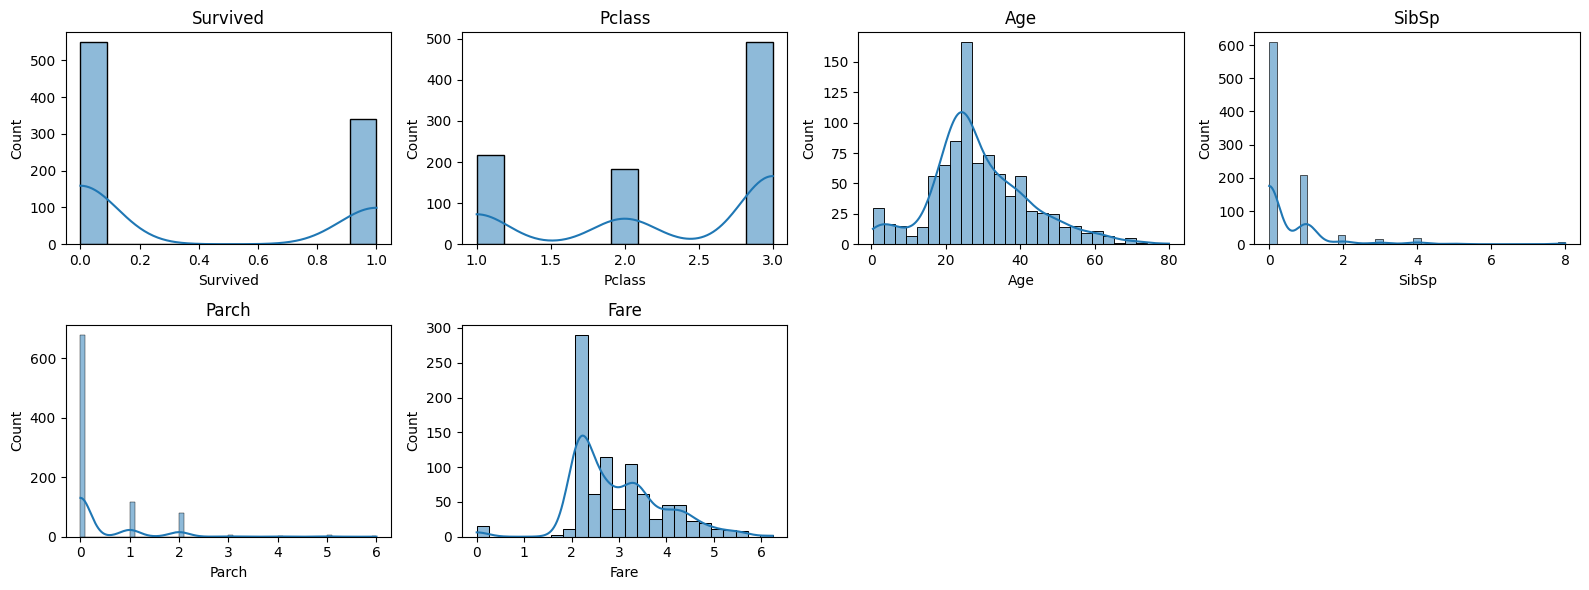

In [651]:
def prepare_skew(df: pd.DataFrame, columns: list[str]):
    for col in columns:
        df[col] = np.log1p(df[col])
    return df

df_linear = prepare_skew(df = df_linear, columns = ['Fare'])

draw_skew(df_linear)

Сделаем `Feature Engineering` (4 штуки)

Определение 3. Feature Engineering - процесс добавления новых зависимостей признаков.

Полиномиальные признаки вводить не будем, потому что в Titanic большинство признаков — категориальные (Sex, Pclass, Embarked) или дискретные счётчики (SibSp, Parch). 

Полиномиализация таких признаков взрывает размерность, создаёт множество искусственных комбинаций без осмысленной интерпретации и повышает риск переобучения, при этом прирост качества для простых моделей минимален. Поэтому будем работать с изначальными признаками.

Добавляем смысловые признаки:

- `FamilySize` = `SibSp` + `Parch` + 1 — размер семейной группы. На шансы спасения влияли семейные связи (могут помогать/мешать выбраться).
- `IsAlone` = 1, если `FamilySize` == 1, иначе 0 — флаг одиночного путешествия. Это даёт модели простой и интерпретируемый сигнал (“один/не один”), который часто оказывается сильнее, чем отдельные SibSp и Parch.


In [652]:
# 1) Размер семьи: братья/сёстры + родители/дети + сам пассажир
df_linear['FamilySize'] = df['SibSp'] + df['Parch'] + 1

# 2) Признак "один" (1) или "с кем-то" (0)
df_linear['IsAlone'] = (df_linear['FamilySize'] == 1).astype("float64")

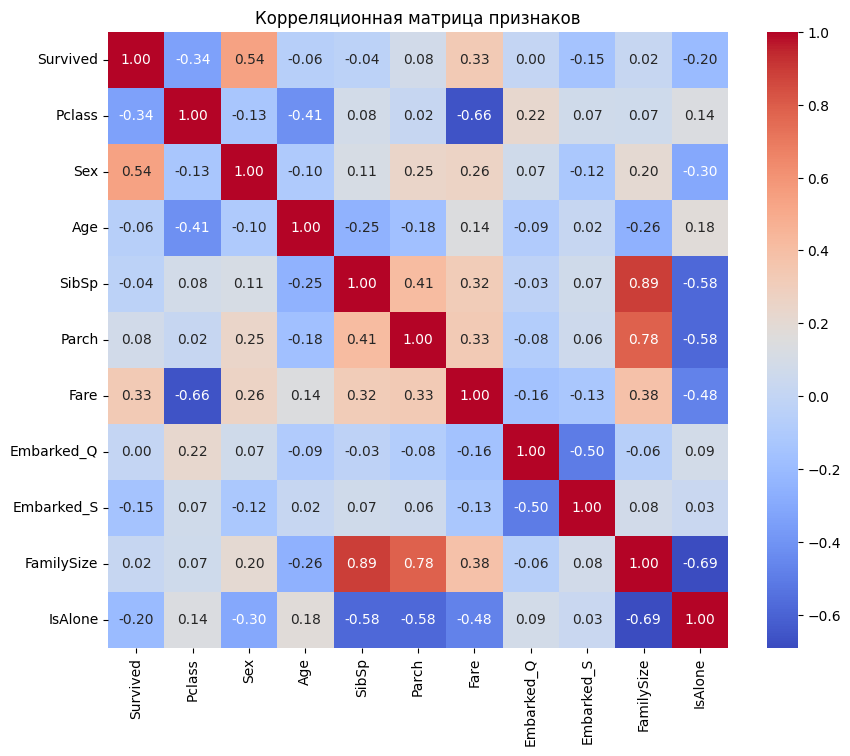

In [653]:
draw_corr_matrix(df_linear)

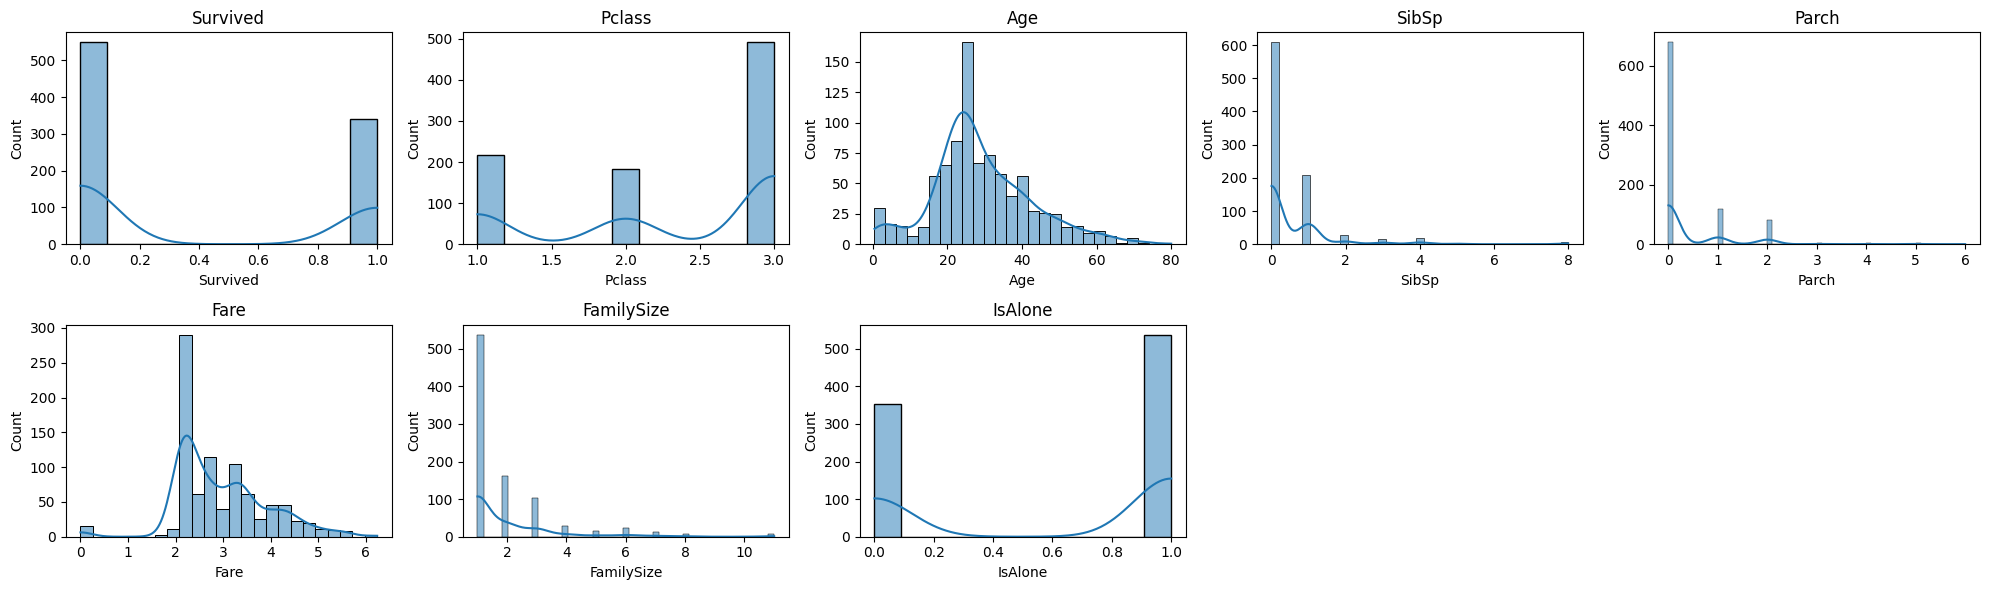

In [654]:
draw_skew(df_linear, 5)

Разделение датасета на признаки и целевую переменную

In [655]:
from sklearn.model_selection import train_test_split

X_linear = df_linear.drop(columns=['Survived'])
y_linear = df_linear['Survived']

# Разделение выборки на test/train (20/80)
X_train_linear, X_test_linear, y_train_linear, y_test_linear = train_test_split(
    X_linear, y_linear, test_size=0.2, random_state=RND_SEED
)

Данные для обучения модели нужно стандартизировать

***Определение 4: Стандартизация признаков — это метод преобразования числовых признаков так, чтобы они имели среднее значение 0 и стандартное отклонение 1. Это важный шаг в подготовке данных для моделей, чувствительных к масштабу признаков, например линейной регрессии, логистической регрессии, SVM, KNN.***

**Как это работает**

Для каждого признака $x$ вычисляется:

$$
x_\text{scaled} = \frac{x - \mu}{\sigma}
$$

где:

* $\mu$ — среднее значение признака в обучающей выборке,
* $\sigma$ — стандартное отклонение признака.

После стандартизации:

* Среднее значение нового признака ≈ 0
* Стандартное отклонение ≈ 1


In [656]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_linear_scaled = scaler.fit_transform(X_train_linear)  # вычисляет среднее и стандартное отклонение (только на train)
X_test_linear_scaled = scaler.transform(X_test_linear)  # применяет эти параметры к любым данным (train, test, новые данные)

#### 1.3.2 Random Forest Classifier

**Особенности модели:**

* Не чувствительна к масштабу признаков.
* Может обрабатывать сильные корреляции между признаками.
* Может использовать категориальные признаки, если они закодированы как числовые.


Сделаем копию датасета

In [657]:
df_forest = df.copy()

Feature engineering

In [658]:
df_forest['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df_forest['IsAlone'] = (df_forest['FamilySize'] == 1).astype(int)

Разделение выборки

In [659]:
X_forest = df_forest.drop(columns=['Survived'])
y_forest = df_forest['Survived']

X_train_forest, X_test_forest, y_train_forest, y_test_forest = train_test_split(
    X_forest, y_forest, test_size=0.2, random_state=RND_SEED
)

#### 1.3.3 XGBoost

**Особенности модели:**

* Градиентный бустинг деревьев.
* Не чувствителен к масштабу.
* Может обрабатывать коррелированные признаки, но слишком много слабых признаков может замедлить обучение.

Сделаем копию датасета

In [660]:
df_xgboost = df.copy()

Feature engineering

In [661]:
df_xgboost['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df_xgboost['IsAlone'] = (df_xgboost['FamilySize'] == 1).astype(int)

Разделение выборки

In [662]:
X_xgboost = df_xgboost.drop(columns=['Survived'])
y_xgboost = df_xgboost['Survived']

X_train_xgboost, X_test_xgboost, y_train_xgboost, y_test_xgboost = train_test_split(
    X_xgboost, y_xgboost, test_size=0.2, random_state=RND_SEED
)

## 2. Создание метрик

1. **MSE (Mean Squared Error)** – средняя квадратичная ошибка:

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

* Чем меньше, тем лучше.
* Чувствительна к выбросам (квадрат ошибки усиливает влияние больших отклонений).

2. **RMSE (Root Mean Squared Error)** – корень из MSE:

$$
\text{RMSE} = \sqrt{\text{MSE}}
$$

* В тех же единицах, что и целевая переменная.
* Легче интерпретировать.

3. **MAE (Mean Absolute Error)** – средняя абсолютная ошибка:

$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
$$

* Менее чувствительна к выбросам, показывает «среднюю ошибку» в исходных единицах.

4. **R² (коэффициент детерминации)**:

$$
R^2 = 1 - \frac{\sum (y_i - \hat{y}_i)^2}{\sum (y_i - \bar{y})^2}
$$

* 1 → идеальное предсказание, 0 → модель не лучше среднего, <0 → хуже среднего.

**Как интерпретировать**

| Метрика | Как читать                    | Что значит для анализа                                                   |
| ------- | ----------------------------- | ------------------------------------------------------------------------ |
| MSE     | Чем меньше, тем точнее        | Показывает среднюю квадратичную ошибку. Выбросы сильно влияют.           |
| RMSE    | В тех же единицах, что и цель | Удобно для прямой интерпретации ошибок.                                  |
| MAE     | Средняя абсолютная ошибка     | Устойчивее к выбросам, показывает среднюю фактическую ошибку.            |
| R²      | 0–1 (или <0)                  | 1 — идеальное совпадение, 0 — предсказывает среднее, <0 — хуже среднего. |

**Пример анализа:**

* Если RMSE и MAE сильно отличаются → есть выбросы.
* Если R² близок к 1 → модель хорошо объясняет вариацию данных.
* Можно сравнивать модели: линейная, RF, XGBoost. Та, у которой меньше RMSE/MAE и выше R² — более точная.


In [663]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def r2(y_true, y_pred):
    return 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))


In [664]:
THRESHOLD = 0.5

def accuracy(y_true, y_pred):
    y_class = (y_pred >= THRESHOLD).astype(int)

    correct = np.sum(y_true == y_pred)
    total = len(y_true)
    return correct / total


def precision(y_true, y_pred):
    y_class = (y_pred >= THRESHOLD).astype(int)

    tp = np.sum((y_true == 1) & (y_class == 1))
    fp = np.sum((y_true == 0) & (y_class == 1))
    if tp + fp == 0:
        return 0.0
    return tp / (tp + fp)


def recall(y_true, y_pred):
    y_class = (y_pred >= THRESHOLD).astype(int)

    tp = np.sum((y_true == 1) & (y_class == 1))
    fn = np.sum((y_true == 1) & (y_class == 0))
    if tp + fn == 0:
        return 0.0
    return tp / (tp + fn)

In [665]:
def get_metrics(y_true, y_pred):
    return {
        'MSE': mse(y_true, y_pred),
        'RMSE': rmse(y_true, y_pred),
        'MAE': mae(y_true, y_pred),
        'R2': r2(y_true, y_pred),
        'Accuracy': accuracy(y_true, y_pred),
        'Precision': precision(y_true, y_pred),
        'Recall': recall(y_true, y_pred)
    }

Прежде чем начнем обучать, создадим `DataFrame` для снятия метрик

In [666]:
# дописать

## 3. Базовая модель линейной регрессии (аналитическое решение)

In [667]:
# Создание линейной модели
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [668]:
# Обучение
lr.fit(X_train_linear_scaled, y_train_linear)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [669]:
# Прогонка и метрики
y_pred = lr.predict(X_test_linear_scaled)
lr_metrics = get_metrics(y_test_linear, y_pred)
lr_metrics

{'MSE': np.float64(0.13813908991730373),
 'RMSE': np.float64(0.3716706740076539),
 'MAE': np.float64(0.2846705103529875),
 'R2': np.float64(0.4303584839072937),
 'Accuracy': np.float64(0.0),
 'Precision': np.float64(0.8),
 'Recall': np.float64(0.7027027027027027)}

## 4. Улучшенная версия линейной регрессии

In [670]:
from sklearn.linear_model import SGDRegressor

### 4.1. Градиентный спуск (симуляция)

In [671]:
# Создание линейной модели градиентного спуска
lr_gd = SGDRegressor(
    max_iter=2000,               # максимум итераций
    tol=1e-6,                    # остановка, когда улучшение < tol
    learning_rate='constant',  # тип изменения шага
    eta0=0.01,                   # стартовый шаг
    penalty='l2',                # регуляризация L2 (Ridge)
    shuffle=False,               # важный момент: не перемешиваем данные, чтобы был настоящий GD
    random_state=RND_SEED
)

In [672]:
# Обучение
lr_gd.fit(X_train_linear_scaled, y_train_linear)

,loss,'squared_error'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,2000
,tol,1e-06
,shuffle,False
,verbose,0
,epsilon,0.1
,random_state,21


In [673]:
# Прогонка и метрики
y_pred = lr_gd.predict(X_test_linear_scaled)
lr_gd_metrics = get_metrics(y_test_linear, y_pred)
lr_gd_metrics

{'MSE': np.float64(0.1457924776831528),
 'RMSE': np.float64(0.3818278115632134),
 'MAE': np.float64(0.3090416474684027),
 'R2': np.float64(0.39879835554106857),
 'Accuracy': np.float64(0.0),
 'Precision': np.float64(0.8225806451612904),
 'Recall': np.float64(0.6891891891891891)}

### 4.2. Стохастический градиентный спуск

In [674]:
# Инициализация модели
lr_sgd = SGDRegressor(
    max_iter=2000,                # максимум итераций
    tol=1e-6,                     # остановка, когда улучшение < tol
    learning_rate='invscaling',   # тип изменения шага
    eta0=0.01,                    # стартовый шаг
    penalty='l1',                 # регуляризация L2 (Ridge)
    random_state=RND_SEED
)

In [675]:
# Обучение
lr_sgd.fit(X_train_linear_scaled, y_train_linear)

,loss,'squared_error'
,penalty,'l1'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,2000
,tol,1e-06
,shuffle,True
,verbose,0
,epsilon,0.1
,random_state,21


In [676]:
# Прогонка и метрики
y_pred = lr_sgd.predict(X_test_linear_scaled)
lr_sgd_metrics = get_metrics(y_test_linear, y_pred)
lr_sgd_metrics

{'MSE': np.float64(0.13845304061789074),
 'RMSE': np.float64(0.37209278495812137),
 'MAE': np.float64(0.2862500332504068),
 'R2': np.float64(0.42906385142370185),
 'Accuracy': np.float64(0.0),
 'Precision': np.float64(0.8),
 'Recall': np.float64(0.7027027027027027)}

### 4.3. Линейная модель с регуляризацией Rigde (L2)

In [677]:
# Инициализация модели
from sklearn.linear_model import Ridge
lr_ridge = Ridge(alpha=1.0)

In [678]:
# Обучение
lr_ridge.fit(X_train_linear_scaled, y_train_linear)

,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [679]:
# Прогонка и метрики
y_pred = lr_ridge.predict(X_test_linear_scaled)
lr_ridge_metrics = get_metrics(y_test_linear, y_pred)
lr_ridge_metrics

{'MSE': np.float64(0.138137536842725),
 'RMSE': np.float64(0.3716685846863103),
 'MAE': np.float64(0.2848145271342619),
 'R2': np.float64(0.4303648882911517),
 'Accuracy': np.float64(0.0),
 'Precision': np.float64(0.8),
 'Recall': np.float64(0.7027027027027027)}

### 4.3. Линейная модель с регуляризацией Lasso (L1)

In [680]:
# Инициализация модели
from sklearn.linear_model import Lasso
lr_lasso = Lasso(alpha=0.01)

In [681]:
# Обучение
lr_lasso.fit(X_train_linear_scaled, y_train_linear)

,alpha,0.01
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,1000
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


In [682]:
# Прогонка и метрики
y_pred = lr_lasso.predict(X_test_linear_scaled)
lr_lasso_metrics = get_metrics(y_test_linear, y_pred)
lr_lasso_metrics

{'MSE': np.float64(0.13996215022785172),
 'RMSE': np.float64(0.3741151563728095),
 'MAE': np.float64(0.29469321602467796),
 'R2': np.float64(0.42284076506427326),
 'Accuracy': np.float64(0.0),
 'Precision': np.float64(0.7910447761194029),
 'Recall': np.float64(0.7162162162162162)}

### 4.4. Линейная модель с регуляризацией ElasticNet (комбинация L1+L2)

In [683]:
# Инициализация модели
from sklearn.linear_model import ElasticNet
lr_enet = ElasticNet(alpha=0.01, l1_ratio=0.5)

In [684]:
# Обучение
lr_enet.fit(X_train_linear_scaled, y_train_linear)

,alpha,0.01
,l1_ratio,0.5
,fit_intercept,True
,precompute,False
,max_iter,1000
,copy_X,True
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


In [685]:
# Прогонка и метрики
y_pred = lr_enet.predict(X_test_linear_scaled)
lr_enet_metrics = get_metrics(y_test_linear, y_pred)
lr_enet_metrics

{'MSE': np.float64(0.1386278847144313),
 'RMSE': np.float64(0.372327657735),
 'MAE': np.float64(0.28957797232559634),
 'R2': np.float64(0.42834285017566376),
 'Accuracy': np.float64(0.0),
 'Precision': np.float64(0.803030303030303),
 'Recall': np.float64(0.7162162162162162)}

## 4. Случайный лес классификатор

In [686]:
# Инициализация модели
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators=200,      # количество деревьев
    max_depth=None,        # глубина деревьев
    random_state=RND_SEED,
    n_jobs=-1              # использовать все ядра процессора
)

In [687]:
# Обучение
rf.fit(X_train_forest, y_train_forest)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [688]:
# Прогонка и метрики
y_pred = rf.predict(X_test_forest)
rf_metrics = get_metrics(y_test_forest, y_pred)
rf_metrics

{'MSE': np.float64(0.17318435754189945),
 'RMSE': np.float64(0.41615424729527806),
 'MAE': np.float64(0.17318435754189945),
 'R2': np.float64(0.28584298584298595),
 'Accuracy': np.float64(0.8268156424581006),
 'Precision': np.float64(0.8208955223880597),
 'Recall': np.float64(0.7432432432432432)}

## 5. Градиентный бустинг (XGBoost)

In [689]:
# Инициализация модели
import xgboost
xgb = xgboost.XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RND_SEED
)

In [690]:
# Обучение
xgb.fit(X_train_xgboost, y_train_xgboost)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [691]:
# Прогонка и метрики
y_pred = xgb.predict(X_test_xgboost)
xgb_metrics = get_metrics(y_test_xgboost, y_pred)
xgb_metrics

{'MSE': np.float64(0.1564245810055866),
 'RMSE': np.float64(0.3955054753168236),
 'MAE': np.float64(0.1564245810055866),
 'R2': np.float64(0.354954954954955),
 'Accuracy': np.float64(0.8435754189944135),
 'Precision': np.float64(0.8484848484848485),
 'Recall': np.float64(0.7567567567567568)}

## 5. Feature Importance

### 5.1 Linear Regression


В **линейных моделях** (LinearRegression, Ridge, Lasso) **feature importance** — это не что иное, как **коэффициенты модели (`coef_`)**.

Но есть нюансы:

* Коэффициенты сами по себе могут быть несопоставимы по масштабу признаков.
* Поэтому мы правильно сделали **стандартизацию (StandardScaler)** → теперь коэффициенты отражают вклад признаков.
* Знак коэффициента (+ / -) показывает направление влияния:

  * `+` → признак увеличивает предсказание качества вина,
  * `-` → уменьшает.


/var/folders/zt/2lht8d7s58j4qg8wh20bn4rh0000gn/T/ipykernel_1627/1675465040.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


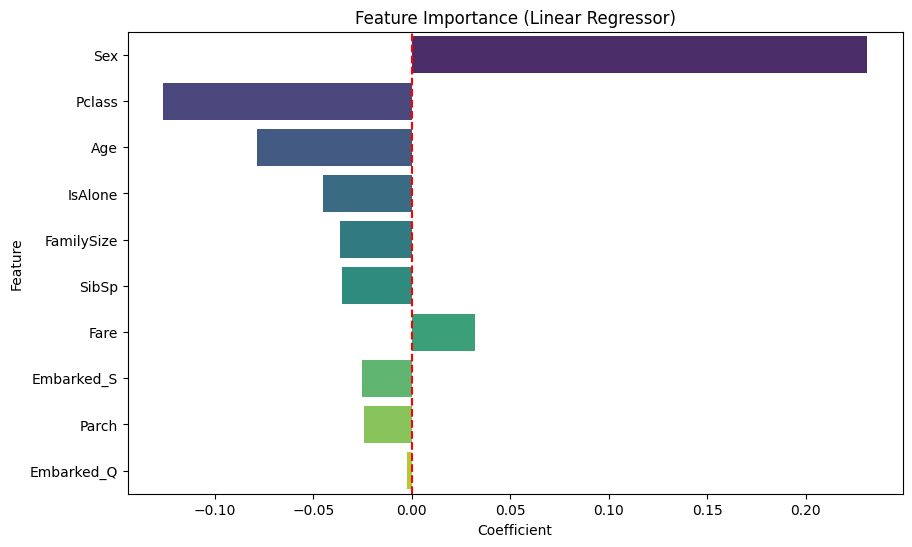

In [692]:
importance = pd.DataFrame({
    'Feature': X_train_linear.columns,
    'Coefficient': lr.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=importance,
    palette='viridis'
)
plt.axvline(0, color='red', linestyle='--')
plt.title('Feature Importance (Linear Regressor)')
plt.show()

### 5.2 Linear Regression (GD)


/var/folders/zt/2lht8d7s58j4qg8wh20bn4rh0000gn/T/ipykernel_1627/1425956437.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


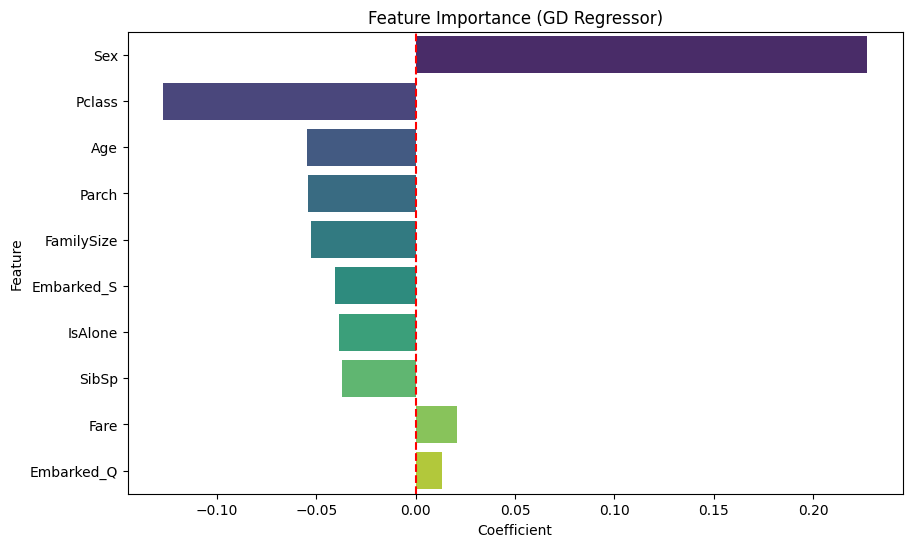

In [693]:
importance = pd.DataFrame({
    'Feature': X_train_linear.columns,
    'Coefficient': lr_gd.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=importance,
    palette='viridis'
)
plt.axvline(0, color='red', linestyle='--')
plt.title('Feature Importance (GD Regressor)')
plt.show()

### 5.3 Linear Regression (SGD)


/var/folders/zt/2lht8d7s58j4qg8wh20bn4rh0000gn/T/ipykernel_1627/1165310945.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


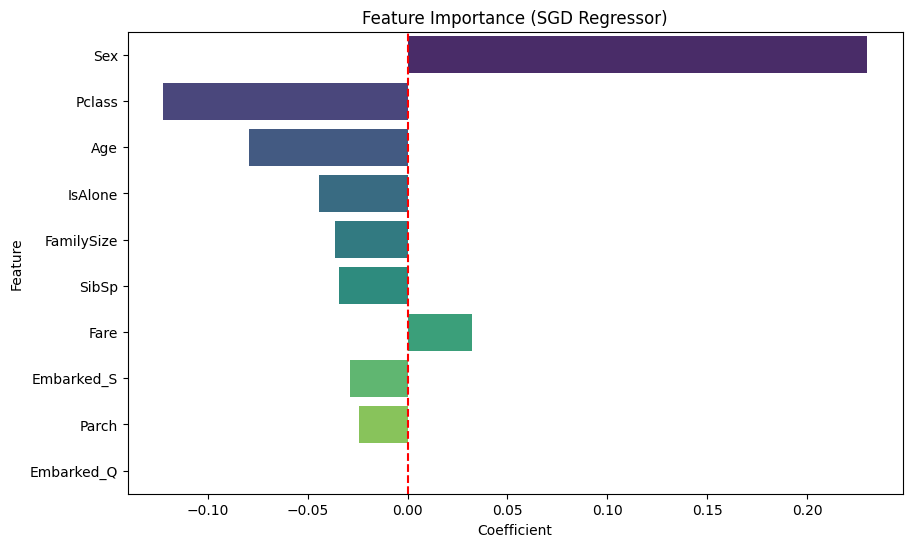

In [694]:
importance = pd.DataFrame({
    'Feature': X_train_linear.columns,
    'Coefficient': lr_sgd.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=importance,
    palette='viridis'
)
plt.axvline(0, color='red', linestyle='--')
plt.title('Feature Importance (SGD Regressor)')
plt.show()

### 5.4 Linear Regression (Rigde)


/var/folders/zt/2lht8d7s58j4qg8wh20bn4rh0000gn/T/ipykernel_1627/647660009.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


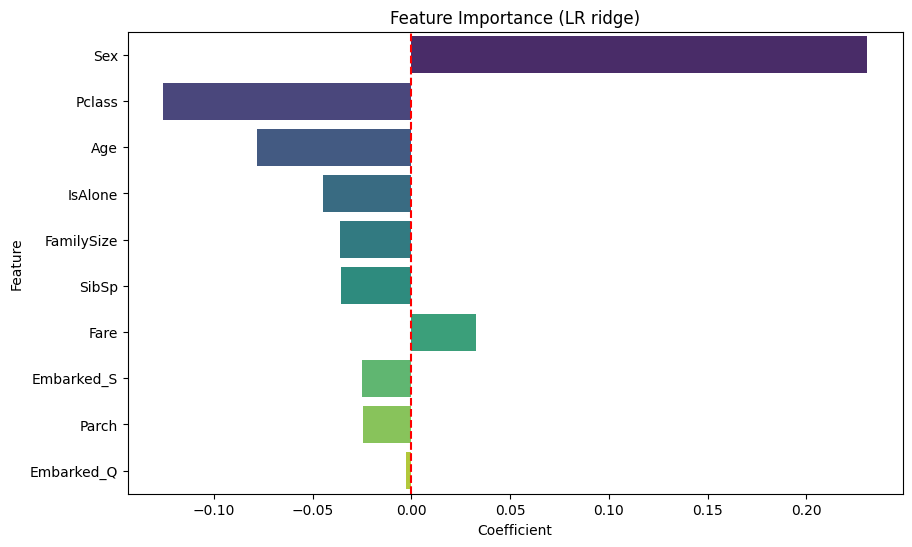

In [695]:
importance = pd.DataFrame({
    'Feature': X_train_linear.columns,
    'Coefficient': lr_ridge.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=importance,
    palette='viridis'
)
plt.axvline(0, color='red', linestyle='--')
plt.title('Feature Importance (LR ridge)')
plt.show()

### 5.5 Linear Regression (Lasso)


/var/folders/zt/2lht8d7s58j4qg8wh20bn4rh0000gn/T/ipykernel_1627/4184585031.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


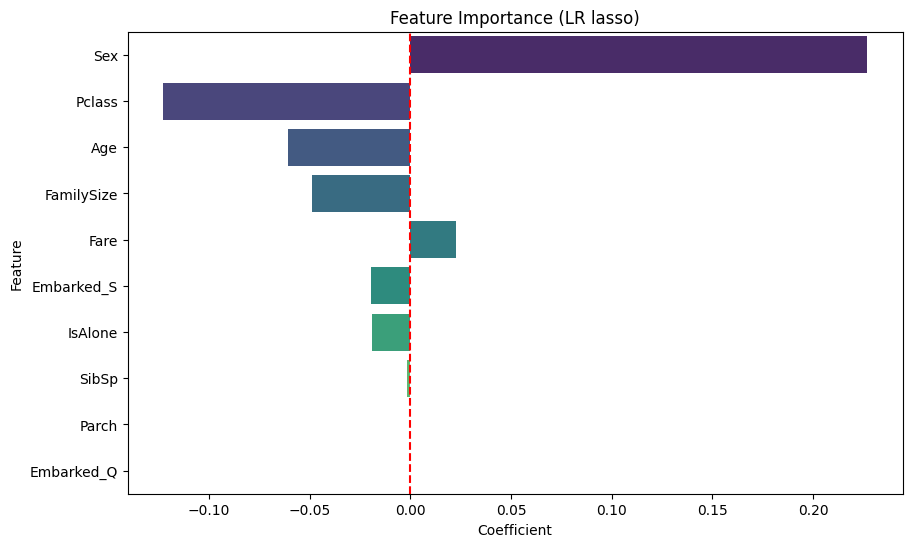

In [696]:
importance = pd.DataFrame({
    'Feature': X_train_linear.columns,
    'Coefficient': lr_lasso.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=importance,
    palette='viridis'
)
plt.axvline(0, color='red', linestyle='--')
plt.title('Feature Importance (LR lasso)')
plt.show()

### 5.6 Linear Regression (ElasticNet)


/var/folders/zt/2lht8d7s58j4qg8wh20bn4rh0000gn/T/ipykernel_1627/319265374.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


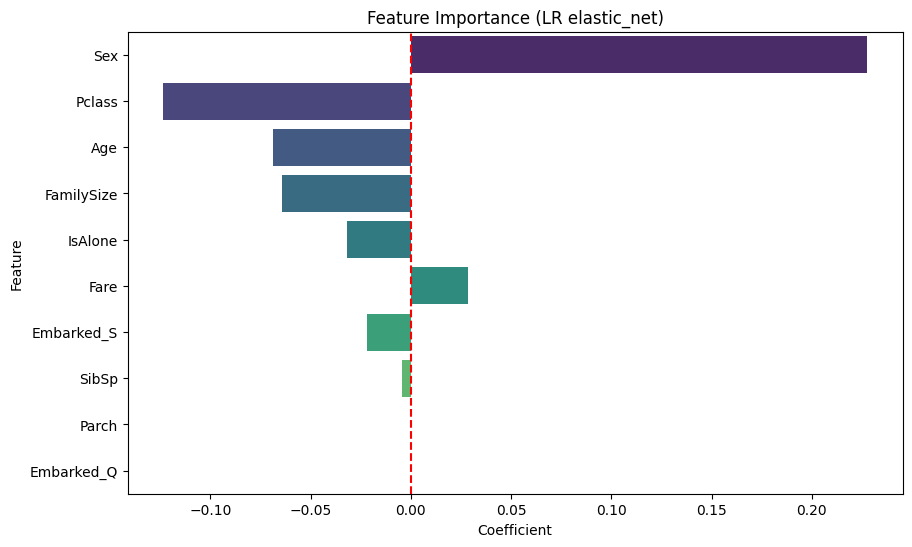

In [697]:
importance = pd.DataFrame({
    'Feature': X_train_linear.columns,
    'Coefficient': lr_enet.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=importance,
    palette='viridis'
)
plt.axvline(0, color='red', linestyle='--')
plt.title('Feature Importance (LR elastic_net)')
plt.show()

### 5.7 Random Forest


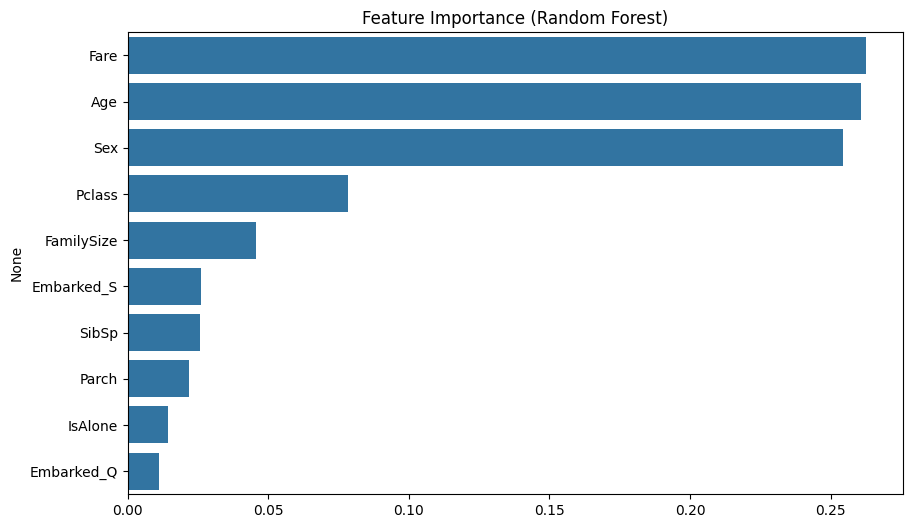

In [698]:
feature_importances = pd.Series(rf.feature_importances_, index=X_forest.columns)
feature_importances = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feature_importances.values, y=feature_importances.index)
plt.title("Feature Importance (Random Forest)")
plt.show()

### 5.6 XGBoost

<Figure size 1000x600 with 0 Axes>

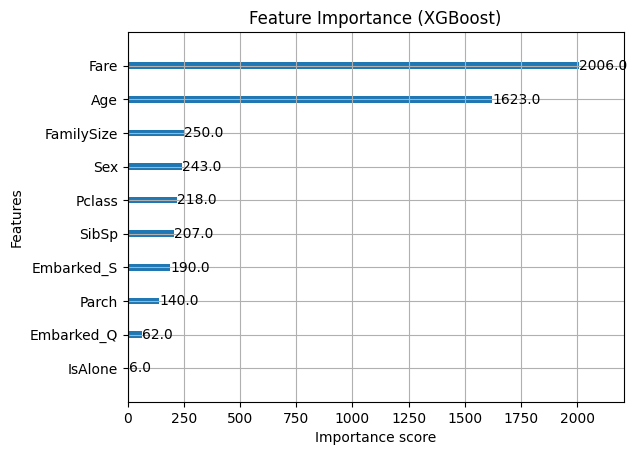

In [699]:
plt.figure(figsize=(10,6))
xgboost.plot_importance(xgb, importance_type='weight', max_num_features=10)
plt.title("Feature Importance (XGBoost)")
plt.show()

## 8. Написание своих реализаций (классы)

Напишите свои классы реализации:

- LR
- LR + GD
- LR + SGD
- *Random Forest (не обязательно)
- *Gradient Boosting Regressor (не обязательно)

In [700]:
from sklearn.base import BaseEstimator, RegressorMixin


class MyLinearRegression(BaseEstimator, RegressorMixin):
    def __init__(
            self, 
            method='analytic', 
            lr=0.01, 
            n_iter=1000, 
            batch_size=32, 
            tol=1e-6, 
            verbose=False
    ):
        self.method = method
        self.lr = lr
        self.n_iter = n_iter
        self.batch_size = batch_size
        self.tol = tol
        self.verbose = verbose

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
    
        n_samples, n_features = X.shape
        X_b = np.hstack([np.ones((n_samples,1)), X])
    
        if self.method == 'analytic':
            self.coef_ = np.linalg.pinv(X_b.T @ X_b) @ X_b.T @ y
        
        elif self.method == 'gd':
            self.coef_ = np.zeros(X_b.shape[1])
            for i in range(self.n_iter):
                preds = X_b @ self.coef_
                grad = (2/n_samples) * X_b.T @ (preds - y)
                update = self.lr * grad
                self.coef_ -= update
                
                if np.linalg.norm(update) < self.tol:
                    if self.verbose:
                        print('Converged at', i)
                    break
        
        elif self.method == 'sgd':
            self.coef_ = np.zeros(X_b.shape[1])
            for epoch in range(self.n_iter):
                idx = np.random.permutation(n_samples)
                X_sh = X_b[idx]
                y_sh = y[idx]
                
                for start in range(0, n_samples, self.batch_size):
                    xb = X_sh[start:start+self.batch_size]
                    yb = y_sh[start:start+self.batch_size]
                    if xb.shape[0] == 0: 
                        continue
                    
                    preds = xb @ self.coef_
                    grad = (2/xb.shape[0]) * xb.T @ (preds - yb)
                    self.coef_ -= self.lr * grad
        else:
            raise ValueError('Unknown method')
        return self

    def predict(self, X):
        X = np.asarray(X)
        X_b = np.hstack([np.ones((X.shape[0],1)), X])
        answer = X_b @ self.coef_
        return np.array([1 if el > 0.5 else 0 for el in answer])

In [ ]:
# Тут мы превратили классификацию в регрессию

my_lr_gd = MyLinearRegression(method='sgd')
my_lr_gd.fit(X_train_linear_scaled, y_train_linear)

y_pred = my_lr_gd.predict(X_test_linear_scaled)
lr_ridge_metrics = get_metrics(y_test_linear, y_pred)
lr_ridge_metrics

{'MSE': np.float64(0.19553072625698323),
 'RMSE': np.float64(0.4421885641408914),
 'MAE': np.float64(0.19553072625698323),
 'R2': np.float64(0.19369369369369382),
 'Accuracy': np.float64(0.8044692737430168),
 'Precision': np.float64(0.8),
 'Recall': np.float64(0.7027027027027027)}

## 9. Итоги

Что сделать?

1. Сгрупировать все метрики, и выяснить, какой методо сработал лучше всего и почему?
2. Ответить на вопросы:

    1. Что такое регрессия и чем она отличается от классификации?
    2. Какова целевая переменная в задаче регрессии?
    3. Зачем нужно масштабирование признаков перед обучением линейной регрессии?
    4. Что означает коэффициент признака в линейной регрессии?
    5. Что такое MSE, RMSE, MAE и R², и чем они отличаются?
    6. В чем разница между Ridge и Lasso регуляризацией?
    7. Почему деревья решений и Random Forest не требуют стандартизации признаков?
    8. Что такое мультиколлинеарность и почему она мешает линейной регрессии?
    9. Как можно уменьшить влияние выбросов на линейную регрессию?
    10. Какие гиперпараметры наиболее важны для Random Forest Regressor?
    11. Какие гиперпараметры наиболее важны для XGBoost в задаче регрессии?
    12. Что значит глубина дерева (max\_depth) и как она влияет на модель?
    13. Зачем нужен `learning_rate` в градиентном бустинге?
    14. Как можно оценить важность признаков (feature importance) в линейной регрессии, случайном лесу и XGBoost?
    15. Почему XGBoost часто работает лучше, чем Random Forest, на структурированных данных?
    16. Что такое переобучение и как его можно выявить на графике обучения?
    17. Как работает метод ансамблирования в Random Forest (bagging)?
    18. В чем отличие бустинга от бэггинга?
    19. Какие способы feature engineering можно применить к датасет?
    20. Как использовать кросс-валидацию для подбора гиперпараметров моделей регрессии?


#### 9.1. Группировка метрик

In [702]:
all_metrics = {
    "LinearRegression":      lr_metrics,
    "GD Regressor":          lr_gd_metrics,
    "SGD Regressor":         lr_sgd_metrics,
    "Ridge (L2)":            lr_ridge_metrics,
    "Lasso (L1)":            lr_lasso_metrics,
    "ElasticNet":            lr_enet_metrics,
    "RandomForest (clf)":    rf_metrics,
    "XGBoost (clf)":         xgb_metrics,
}

metrics_df = pd.DataFrame(all_metrics).T

cols = [c for c in ["MSE", "RMSE", "MAE", "R2", "Accuracy", "Precision", "Recall"] if c in metrics_df.columns]
metrics_df = metrics_df[cols]

# округлим и отсортируем по MSE (меньше — лучше)
metrics_df = metrics_df.round(4).sort_values(by=cols[0] if cols else metrics_df.columns[0])

metrics_df


,MSE,RMSE,MAE,R2,Accuracy,Precision,Recall
LinearRegression,0.1381,0.3717,0.2847,0.4304,0.0000,0.8000,0.7027
SGD Regressor,0.1385,0.3721,0.2863,0.4291,0.0000,0.8000,0.7027
ElasticNet,0.1386,0.3723,0.2896,0.4283,0.0000,0.8030,0.7162
Lasso (L1),0.1400,0.3741,0.2947,0.4228,0.0000,0.7910,0.7162
GD Regressor,0.1458,0.3818,0.3090,0.3988,0.0000,0.8226,0.6892
XGBoost (clf),0.1564,0.3955,0.1564,0.3550,0.8436,0.8485,0.7568
RandomForest (clf),0.1732,0.4162,0.1732,0.2858,0.8268,0.8209,0.7432
Ridge (L2),0.1955,0.4422,0.1955,0.1937,0.8045,0.8000,0.7027


## Ответы на вопросы

### 1. Разница между регрессией и классификацией
- **Регрессия** — предсказывает **числовое значение** (например, цену квартиры, температуру, рост).  
- **Классификация** — предсказывает **категорию** (например, "спам / не спам", "здоров / болен").  

### 2. Что такое целевая переменная в регрессии
Это то, **что мы хотим предсказать** — результат.  
Например: если у нас есть данные о квартирах, то целевая переменная — это **цена квартиры**.

### 3. Зачем масштабировать признаки в линейной регрессии
Если один признак измеряется в километрах, а другой — в миллиметрах, модель "съедет с ума".  
Масштабирование (StandardScaler, MinMaxScaler) помогает:
- чтобы признаки имели одинаковый масштаб;
- чтобы обучение шло стабильно и коэффициенты имели смысл;
- чтобы регуляризация работала правильно.

### 4. Что показывает коэффициент признака
Он показывает, **насколько изменится предсказание**, если признак увеличится на 1 (при прочих равных).  
- Знак коэффициента — направление влияния (положительное или отрицательное).  
- Модуль — сила влияния.  

### 5. Основные метрики регрессии
- **MSE (Mean Squared Error)** — средний квадрат ошибки (сильно штрафует выбросы).  
- **RMSE** — то же самое, но с корнем (в тех же единицах, что и целевая).  
- **MAE (Mean Absolute Error)** — средняя абсолютная ошибка (устойчивее к выбросам).  
- **R²** — насколько хорошо модель объясняет вариацию данных (1 — идеально, 0 — не лучше среднего).

### 6. Ridge и Lasso
Обе — регуляризованные версии линейной регрессии:
- **Ridge (L2)**: «сжимает» коэффициенты, но не зануляет их.  
- **Lasso (L1)**: может занулять некоторые коэффициенты → делает отбор признаков.  
Часто используют **ElasticNet** — смесь Ridge и Lasso.

### 7. Почему деревья и Random Forest не требуют стандартизации
Потому что деревья делят данные по принципу «больше/меньше», а не по масштабу.  
Им без разницы, метры это или километры — порядок сохраняется.

### 8. Что такое мультиколлинеарность
Когда признаки **сильно коррелируют** между собой (пример: "рост в см" и "рост в м").  
Это мешает линейным моделям — коэффициенты становятся нестабильными и плохо интерпретируются.

### 9. Как уменьшить влияние выбросов
- Преобразовать данные (логарифм, корень).  
- Ограничить выбросы (винсоризация, обрезка).  
- Использовать робастные метрики/модели (MAE, Huber, RANSAC).  
- Проверить корректность данных (часто выбросы — ошибки измерения).

### 10. Важные гиперпараметры RandomForestRegressor
- `n_estimators` — количество деревьев (обычно 100–500).  
- `max_depth` — глубина деревьев (чем больше, тем сложнее).  
- `max_features` — сколько признаков брать на каждом сплите.  
- `min_samples_split`, `min_samples_leaf` — минимальное количество объектов для разбиения.  
- `bootstrap` — использовать ли бутстрап (обычно True).

### 11. Основные гиперпараметры XGBoost
- `n_estimators` — количество деревьев.  
- `learning_rate` — шаг обучения (меньше → стабильнее, но нужно больше деревьев).  
- `max_depth` — глубина деревьев.  
- `min_child_weight`, `subsample`, `colsample_bytree` — контролируют переобучение.  
- `reg_alpha`, `reg_lambda` — L1/L2-регуляризация.  

### 12. Влияние глубины дерева (max_depth)
- Маленькая глубина → простая модель, может недообучиться.  
- Большая глубина → сложная модель, может переобучиться.  
Обычно подбирается с помощью кросс-валидации.

### 13. Зачем нужен learning_rate в бустинге
Это «шаг» обновления при добавлении новых деревьев.  
- Малый шаг → модель учится медленно, но стабильнее.  
- Большой шаг → быстрее, но может переобучиться.  
Комбинируется с количеством деревьев.

### 14. Как оценить важность признаков
- **В линейной модели** — по модулю коэффициентов.  
- **В деревьях/бустинге** — по тому, насколько часто и полезно признак использовался для разбиений.  
- **Современные методы**: Permutation Importance и SHAP — дают более точное представление.

### 15. Почему XGBoost часто лучше Random Forest
- Он **учится последовательно**, исправляя ошибки предыдущих деревьев.  
- Имеет гибкую **регуляризацию** и **тонкую настройку**.  
- Может **автоматически обрабатывать пропуски**.  
Поэтому обычно точнее, но чувствительнее к параметрам.

### 16. Как выглядит переобучение
- Ошибка на обучении маленькая, а на проверке — большая.  
- На графике обучения видно: train-ошибка падает, а val-ошибка перестаёт улучшаться или растёт.  
Значит, модель слишком подогналась под обучение.

### 17. Как работает бэггинг в Random Forest
Бэггинг = **Bootstrap + Aggregating**.  
- Берём случайные подвыборки данных, обучаем отдельные деревья.  
- Усредняем их предсказания.  
Результат — меньше разброс, модель стабильнее.

### 18. Разница между бэггингом и бустингом
| Характеристика | Бэггинг | Бустинг |
|-----------------|----------|----------|
| Обучение | Параллельно | Последовательно |
| Цель | Снизить разброс | Снизить смещение |
| Пример | Random Forest | XGBoost, LightGBM |
| Риск переобучения | Низкий | Выше, если не регулировать |

### 19. Примеры feature engineering
- Логарифмы, степени, взаимодействия признаков.  
- Кодирование категориальных переменных.  
- Разбор дат на год, месяц, день, день недели.  
- Агрегации по группам (среднее, максимум и т. д.).  
- Работа с пропусками и выбросами.  
Feature engineering помогает дать модели более информативные признаки.

### 20. Как кросс-валидация помогает подбирать гиперпараметры
Кросс-валидация делит данные на несколько частей (**folds**):
1. Обучаемся на части фолдов, проверяем на оставшемся.  
2. Повторяем несколько раз и усредняем метрику.  
3. Выбираем параметры, где метрика лучшая.  
Это даёт честную оценку качества и предотвращает случайное переобучение.